In [23]:
import math

import torch
import torchmetrics.classification
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix

from dataset import val_set_with_metadata
from main import ResNetModel
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import variance

In [24]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = ResNetModel.load_from_checkpoint('resnet18-1.cpkt', map_location=device)

trainer = pl.Trainer(
    # We run on a single GPU (if possible)
    accelerator="auto",
    devices=1,
    # How many epochs to train for if no patience is set
    max_epochs=10,
    logger=False,
)


val_loader = DataLoader(val_set_with_metadata, batch_size=1, shuffle=False, drop_last=False, num_workers=1)

all_labels = []
for batch in val_loader:
    imgs, labels = batch
    all_labels.append(labels)

print(all_labels)
predictions = trainer.predict(model, val_loader)
predictions = torch.cat(predictions)
print(predictions)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


[[tensor([1]), tensor([60.], dtype=torch.float64), ('female',)], [tensor([1]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([2]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([30.], dtype=torch.float64), ('female',)], [tensor([3]), tensor([80.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([45.], dtype=torch.float64), ('male',)], [tensor([0]), tensor([80.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([40.], dtype=torch.float64), ('female',)], [tensor([1]), tensor([75.], dtype=torch.float64), ('male',)], [tensor([2]), tensor([65.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([45.], dtype=torch.float64), ('female',)], [tensor([1]), tensor([50.], dtype=torch.float64), ('female',)], [tensor([1]), tensor([35.], dtype=torch.float64), ('female',)], [tensor([2]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([35.], dtype=torch.float64), ('male'

Predicting: 0it [00:00, ?it/s]

tensor([2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 2, 3, 1, 0, 2, 3, 2, 1,
        1, 1, 1, 1, 1, 3, 1, 1, 2, 0, 3, 2, 3, 2, 1, 1, 3, 1, 3, 1, 2, 3, 1, 1,
        3, 0, 1, 3, 3, 1, 0, 3, 2, 1, 3, 2, 1, 3, 1, 0, 0, 3, 3, 1, 2, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 2, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 3, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 3, 0, 3, 2, 1, 0, 0,
        1, 3, 3, 1, 1, 0, 1, 1, 2, 0, 0, 3, 3, 3, 1, 1, 3, 2, 0, 1, 0, 1, 1, 3,
        2, 3, 0, 3, 3, 2, 3, 3, 0, 0, 2, 0, 2, 0, 3, 2, 2, 2, 0, 0, 0, 1, 1, 1,
        2, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 2, 2])


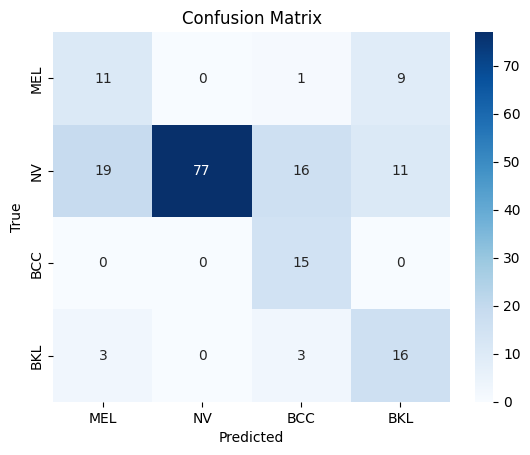

In [25]:
confm = ConfusionMatrix(task="multiclass", num_classes=4)

confm_labels = []
for label in all_labels:
    confm_labels.append(label[0])

confm_labels = torch.cat(confm_labels)

result = confm(predictions, confm_labels)

labels = ["MEL", "NV", "BCC", "BKL"]
sns.heatmap(result, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("conf_ma.png")

# wandb.log({"confma": wandb.Image("conf_ma.png")})


In [28]:
# calculate accuracy based on sex

male_predictions = []
male_labels = []
female_predictions = []
female_labels = []

for i in range(len(predictions)):
    if all_labels[i][2][0] == 'male':
        male_predictions.append(torch.unsqueeze(predictions[i], dim=0))
        male_labels.append(all_labels[i][0])
    elif all_labels[i][2][0] == 'female':
        female_predictions.append(torch.unsqueeze(predictions[i], dim=0))
        female_labels.append(all_labels[i][0])
    else:
        print(f"unknown: {all_labels[i][2]}")

print(male_labels)
print(male_predictions)

metric = torchmetrics.classification.MulticlassAccuracy(num_classes=4, average='weighted')

male_accuracy = metric(torch.cat(male_predictions), torch.cat(male_labels))
female_accuracy = metric(torch.cat(female_predictions), torch.cat(female_labels))

overall_accuracy = metric(predictions, confm_labels)

#wandb.log({"overall_accuracy": overall_accuracy})
#wandb.log({"male_accuracy": male_accuracy})
print(f"male_acc: {male_accuracy}")
#wandb.log({"female_accuracy": female_accuracy})
print(f"female_acc: {female_accuracy}")

print(f"bias: {variance([male_accuracy.item(), female_accuracy.item()])}")


[tensor([1]), tensor([2]), tensor([1]), tensor([3]), tensor([1]), tensor([0]), tensor([1]), tensor([2]), tensor([2]), tensor([1]), tensor([1]), tensor([0]), tensor([2]), tensor([2]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([3]), tensor([2]), tensor([3]), tensor([1]), tensor([1]), tensor([3]), tensor([1]), tensor([3]), tensor([1]), tensor([3]), tensor([3]), tensor([1]), tensor([1]), tensor([0]), tensor([2]), tensor([1]), tensor([0]), tensor([1]), tensor([3]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([2]), tensor([2]), tensor([2]), tensor([1]), tensor([2]), tensor([3]), tensor([1]), tensor([3]), tensor([2]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([3]), tensor([1]), tensor([3]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1])

In [30]:
age_groups = ["85.0", "80.0", "75.0", "65.0", "60.0", "55.0", "50.0", "45.0", "40.0", "35.0", "30.0", "25.0", "20.0", "15.0", "10.0", "5.0", "0.0", "-10.0"]
            

age_based_predictions = {"85.0": [], "80.0": [], "75.0": [], "70.0": [], "65.0": [], "60.0": [], "55.0": [], "50.0": [], "45.0": [], "40.0": [], "35.0": [], "30.0": [], "25.0": [], "20.0": [], "15.0": [], "10.0": [], "5.0": [], "0.0": [], "-10.0": []}
age_labels = {"85.0": [], "80.0": [], "75.0": [], "70.0": [], "65.0": [], "60.0": [], "55.0": [], "50.0": [], "45.0": [], "40.0": [], "35.0": [], "30.0": [], "25.0": [], "20.0": [], "15.0": [], "10.0": [], "5.0": [], "0.0": [], "-10.0": []}

for i in range(len(predictions)):
    age = str(all_labels[i][1][0].item())

    age_based_predictions[age].append(torch.unsqueeze(predictions[i], dim=0))
    age_labels[age].append(all_labels[i][0])
    

metric = torchmetrics.classification.MulticlassAccuracy(num_classes=4, average='weighted')

accuracies = {}
acc_list = []
for age in age_groups:
    print(f"{age} has {len(age_based_predictions[age])} samples")
    if age == "-10.0":
        continue
    if len(age_based_predictions[age]) > 0:
        accuracies[age] = metric(torch.cat(age_based_predictions[age]), torch.cat(age_labels[age])).item()
        acc_list.append(accuracies[age])

overall_accuracy = metric(predictions, confm_labels)

print(accuracies)
print(f"overall_accuracy: {overall_accuracy}")



print(f"bias: {variance(acc_list)}")




85.0 has 8 samples
80.0 has 6 samples
75.0 has 7 samples
65.0 has 29 samples
60.0 has 18 samples
55.0 has 10 samples
50.0 has 26 samples
45.0 has 21 samples
40.0 has 11 samples
35.0 has 16 samples
30.0 has 6 samples
25.0 has 0 samples
20.0 has 2 samples
15.0 has 0 samples
10.0 has 0 samples
5.0 has 1 samples
0.0 has 0 samples
-10.0 has 0 samples
{'85.0': 0.625, '80.0': 0.6666666865348816, '75.0': 0.4285714328289032, '65.0': 0.6551724076271057, '60.0': 0.5, '55.0': 0.8999999761581421, '50.0': 0.6538462042808533, '45.0': 0.6190476417541504, '40.0': 0.7272727489471436, '35.0': 0.5, '30.0': 0.6666666865348816, '20.0': 1.0, '5.0': 1.0}
overall_accuracy: 0.6574586033821106
bias: 0.032586921977467063
